FASE 0 — (opcional) Instalação

In [ ]:
# Se necessário, rode esta célula uma única vez
# !pip3 install yfinance pandas numpy python-dateutil matplotlib

FASE 1 — Imports, parâmetros e entrada

In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from functools import lru_cache
import matplotlib.pyplot as plt
from typing import Union

# 🔧 Parâmetros principais
TICKERS_RAW = "TGAR11, HABT11, IRDM11, RBED11, HSML11"  # edite aqui, separado por vírgula
CONSIDERAR_ULTIMO_MES_CIVIL = True      # True = mês civil anterior; False = últimos 30 dias corridos

def limpar_ticker(t: str) -> str:
    t = t.strip().upper()
    return t if t.endswith(".SA") else f"{t}.SA"

TICKERS = [limpar_ticker(t) for t in TICKERS_RAW.split(",") if t.strip()]
TICKERS


['TGAR11.SA', 'HABT11.SA', 'IRDM11.SA', 'RBED11.SA', 'HSML11.SA']

FASE 2 — Utilidades de datas

In [13]:
def inicio_fim_ultimo_mes(ref: datetime | None = None) -> tuple[datetime, datetime]:
    """Retorna (início, fim) do último mês civil completo."""
    if ref is None:
        ref = datetime.now()
    primeiro_deste_mes = ref.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
    fim_ultimo_mes = primeiro_deste_mes - timedelta(seconds=1)
    inicio_ultimo_mes = (primeiro_deste_mes - relativedelta(months=1)).replace(
        day=1, hour=0, minute=0, second=0, microsecond=0
    )
    return inicio_ultimo_mes, fim_ultimo_mes

def window_start(months: int, ref: datetime | None = None) -> datetime:
    if ref is None:
        ref = datetime.now()
    return (ref - relativedelta(months=months)).replace(hour=0, minute=0, second=0, microsecond=0)



def drop_tz_index(obj: Union[pd.Series, pd.DataFrame]):
    """
    Devolve uma cópia com index Datetime sem timezone (tz-naive).
    Ignora silenciosamente se já for tz-naive.
    """
    cpy = obj.copy()
    if isinstance(cpy.index, pd.DatetimeIndex):
        try:
            cpy.index = pd.to_datetime(cpy.index).tz_localize(None)
        except Exception:
            # já é tz-naive ou não é convertível
            pass
    return cpy

def now_naive() -> pd.Timestamp:
    # Timestamp sem timezone
    return pd.Timestamp.now(tz=None)



FASE 3 — Baixa dados (com cache)

Usa 2 anos de histórico para ter folga.

dividends é a série de proventos por cota.

In [14]:
@lru_cache(maxsize=256)
def baixar_dados(ticker: str):
    t = yf.Ticker(ticker)
    hist = t.history(period="2y", auto_adjust=False)   # DF OHLCV
    dividends = t.dividends                             # Série de proventos
    # 🧼 Remover timezone dos índices
    hist = drop_tz_index(hist)
    dividends = drop_tz_index(dividends)
    return hist, dividends



FASE 4 — Cálculos de métricas por ticker

In [15]:
def calcular_metricas(ticker: str, considerar_mes_civil=True) -> dict:
    try:
        hist, dividends = baixar_dados(ticker)
        if hist.empty:
            return {"Ticker": ticker.replace(".SA", ""), "Erro": "Sem histórico"}

        close_series = hist["Close"].dropna()
        ultimo_close = float(close_series.iloc[-1])

        # variação 12m (%)
        corte_12m = close_series.index.max() - pd.Timedelta(days=365)
        hist_12m = close_series[close_series.index >= corte_12m]
        if hist_12m.empty:
            variacao_12m_pct = np.nan
        else:
            preco_12m = float(hist_12m.iloc[0])
            variacao_12m_pct = (ultimo_close / preco_12m - 1.0) * 100.0

        # dividendos (~14 meses p/ folga), garantindo índices tz-naive
        agora = now_naive()
        div = dividends
        if not isinstance(div.index, pd.DatetimeIndex):
            div.index = pd.to_datetime(div.index)
        div = drop_tz_index(div)
        div = div[div.index >= (agora - relativedelta(months=14))]

        # janelas
        j3  = div[div.index >= (agora - relativedelta(months=3))]
        j6  = div[div.index >= (agora - relativedelta(months=6))]
        j12 = div[div.index >= (agora - relativedelta(months=12))]

        soma_3m, soma_6m, soma_12m = float(j3.sum()), float(j6.sum()), float(j12.sum())
        media_mensal_3m  = soma_3m  / 3.0
        media_mensal_6m  = soma_6m  / 6.0
        media_mensal_12m = soma_12m / 12.0

        # último mês
        if considerar_mes_civil:
            # mês civil anterior (naive)
            primeiro_deste_mes = agora.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
            fim_ultimo_mes = primeiro_deste_mes - pd.Timedelta(seconds=1)
            inicio_ultimo_mes = (primeiro_deste_mes - relativedelta(months=1)).replace(
                day=1, hour=0, minute=0, second=0, microsecond=0
            )
            ultimo_mes = div[(div.index >= inicio_ultimo_mes) & (div.index <= fim_ultimo_mes)]
        else:
            ultimo_mes = div[div.index >= (agora - pd.Timedelta(days=30))]
        soma_ultimo_mes = float(ultimo_mes.sum()) if len(ultimo_mes) else 0.0

        # % do preço
        def pct_parte_do_preco(valor: float) -> float:
            return (valor / ultimo_close * 100.0) if ultimo_close else np.nan

        pct_mensal_3m   = pct_parte_do_preco(media_mensal_3m)
        pct_mensal_6m   = pct_parte_do_preco(media_mensal_6m)
        pct_mensal_12m  = pct_parte_do_preco(media_mensal_12m)
        pct_ultimo_mes  = pct_parte_do_preco(soma_ultimo_mes)
        yield_ttm_pct   = pct_parte_do_preco(soma_12m)

        return {
            "Ticker": ticker.replace(".SA", ""),
            "Preço atual": round(ultimo_close, 2),
            "Δ 12m (%)": round(variacao_12m_pct, 2) if not np.isnan(variacao_12m_pct) else np.nan,

            "Média mensal 3m (R$)": round(media_mensal_3m, 4),
            "% do preço (3m/mês)": round(pct_mensal_3m, 3),

            "Média mensal 6m (R$)": round(media_mensal_6m, 4),
            "% do preço (6m/mês)": round(pct_mensal_6m, 3),

            "Média mensal 12m (R$)": round(media_mensal_12m, 4),
            "% do preço (12m/mês)": round(pct_mensal_12m, 3),

            "Último mês (R$)": round(soma_ultimo_mes, 4),
            "% do preço (últ. mês)": round(pct_ultimo_mes, 3),

            "Proventos 12m (R$)": round(soma_12m, 4),
            "Yield TTM (%)": round(yield_ttm_pct, 3),
        }
    except Exception as e:
        return {"Ticker": ticker.replace(".SA", ""), "Erro": str(e)}


FASE 5 — Processa a lista de tickers e cria o DataFrame final

In [16]:
resultados = [calcular_metricas(t, considerar_mes_civil=CONSIDERAR_ULTIMO_MES_CIVIL) for t in TICKERS]
df = pd.DataFrame(resultados)

# Ordena as colunas numa ordem amigável (se existirem)
colunas = [
    "Ticker", "Preço atual", "Δ 12m (%)",
    "Média mensal 3m (R$)", "% do preço (3m/mês)",
    "Média mensal 6m (R$)", "% do preço (6m/mês)",
    "Média mensal 12m (R$)", "% do preço (12m/mês)",
    "Último mês (R$)", "% do preço (últ. mês)",
    "Proventos 12m (R$)", "Yield TTM (%)", "Erro"
]
df = df[[c for c in colunas if c in df.columns]]
df


,Ticker,Preço atual,Δ 12m (%),Média mensal 3m (R$),% do preço (3m/mês),Média mensal 6m (R$),% do preço (6m/mês),Média mensal 12m (R$),% do preço (12m/mês),Último mês (R$),% do preço (últ. mês),Proventos 12m (R$),Yield TTM (%)
0,TGAR11,84.76,-14.90,1.0000,1.180,1.0000,1.180,1.0208,1.204,1.00,1.180,12.2500,14.453
1,HABT11,69.43,-12.30,0.9833,1.416,1.0500,1.512,1.0583,1.524,0.95,1.368,12.7000,18.292
2,IRDM11,58.50,-14.54,0.7467,1.276,0.7883,1.348,0.7875,1.346,0.76,1.299,9.4500,16.154
3,RBED11,94.03,-33.30,0.0000,0.000,0.0000,0.000,0.3019,0.321,0.00,0.000,3.6232,3.853
4,HSML11,85.28,-2.10,0.6833,0.801,0.6683,0.784,0.6842,0.802,0.68,0.797,8.2100,9.627


FASE 6 — (opcional) Formatação rápida para exibição

In [17]:
def fmt_pct(x):
    return "" if pd.isna(x) else f"{x:.2f}%"

def fmt_moeda(x):
    return "" if pd.isna(x) else f"R$ {x:,.4f}".replace(",", "X").replace(".", ",").replace("X", ".")

df_show = df.copy()
for c in ["% do preço (3m/mês)", "% do preço (6m/mês)", "% do preço (12m/mês)", "% do preço (últ. mês)", "Yield TTM (%)", "Δ 12m (%)"]:
    if c in df_show.columns:
        df_show[c] = df_show[c].map(fmt_pct)
for c in ["Média mensal 3m (R$)", "Média mensal 6m (R$)", "Média mensal 12m (R$)", "Último mês (R$)", "Proventos 12m (R$)", "Preço atual"]:
    if c in df_show.columns:
        df_show[c] = df_show[c].map(lambda v: v if c=="Preço atual" else fmt_moeda(v))
df_show


,Ticker,Preço atual,Δ 12m (%),Média mensal 3m (R$),% do preço (3m/mês),Média mensal 6m (R$),% do preço (6m/mês),Média mensal 12m (R$),% do preço (12m/mês),Último mês (R$),% do preço (últ. mês),Proventos 12m (R$),Yield TTM (%)
0,TGAR11,84.76,-14.90%,"R$ 1,0000",1.18%,"R$ 1,0000",1.18%,"R$ 1,0208",1.20%,"R$ 1,0000",1.18%,"R$ 12,2500",14.45%
1,HABT11,69.43,-12.30%,"R$ 0,9833",1.42%,"R$ 1,0500",1.51%,"R$ 1,0583",1.52%,"R$ 0,9500",1.37%,"R$ 12,7000",18.29%
2,IRDM11,58.50,-14.54%,"R$ 0,7467",1.28%,"R$ 0,7883",1.35%,"R$ 0,7875",1.35%,"R$ 0,7600",1.30%,"R$ 9,4500",16.15%
3,RBED11,94.03,-33.30%,"R$ 0,0000",0.00%,"R$ 0,0000",0.00%,"R$ 0,3019",0.32%,"R$ 0,0000",0.00%,"R$ 3,6232",3.85%
4,HSML11,85.28,-2.10%,"R$ 0,6833",0.80%,"R$ 0,6683",0.78%,"R$ 0,6842",0.80%,"R$ 0,6800",0.80%,"R$ 8,2100",9.63%


FASE 7 — Gráfico de preços (12m) — 1 figura por ticker (matplotlib)

Atenção: uma figura por vez (sem subplots) e sem estilos/cores específicos.

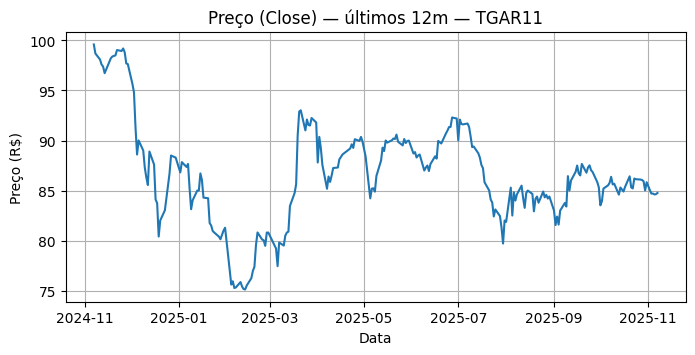

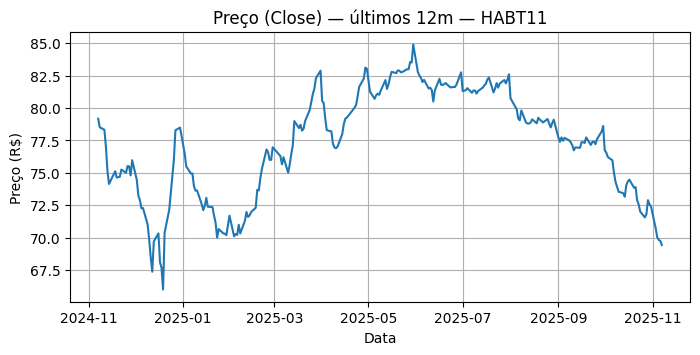

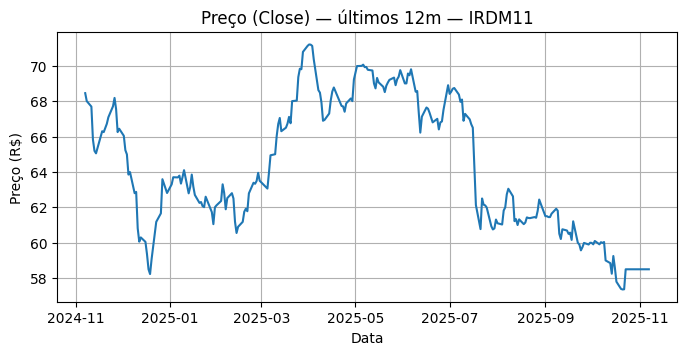

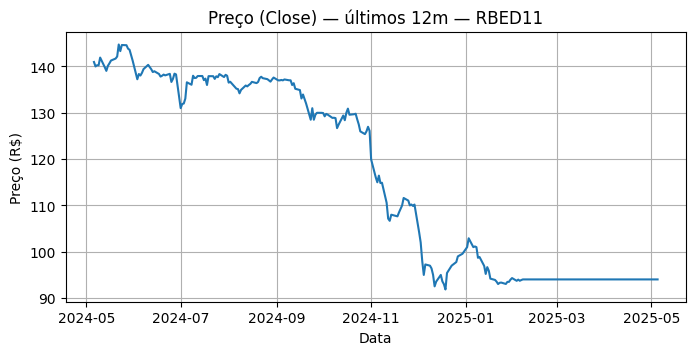

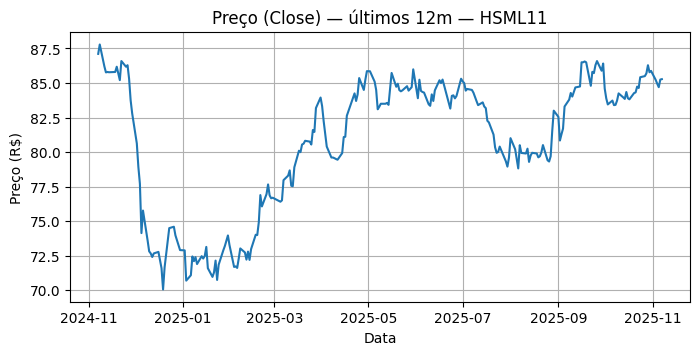

In [18]:
for tk in TICKERS:
    hist, _ = baixar_dados(tk)
    closes = hist["Close"].dropna()
    if closes.empty:
        print(f"[AVISO] Sem preços para {tk}")
        continue
    corte = closes.index.max() - pd.Timedelta(days=365)
    serie = closes[closes.index >= corte]
    if serie.empty:
        print(f"[AVISO] Sem janela 12m para {tk}")
        continue

    plt.figure(figsize=(8, 3.5))
    plt.plot(serie.index, serie.values)
    plt.title(f"Preço (Close) — últimos 12m — {tk.replace('.SA','')}")
    plt.xlabel("Data")
    plt.ylabel("Preço (R$)")
    plt.grid(True)
    plt.show()


FASE 8 — Gráfico de proventos por mês (barra) — 1 figura por ticker

Agrega dividendos por período mensal (YYYY-MM).

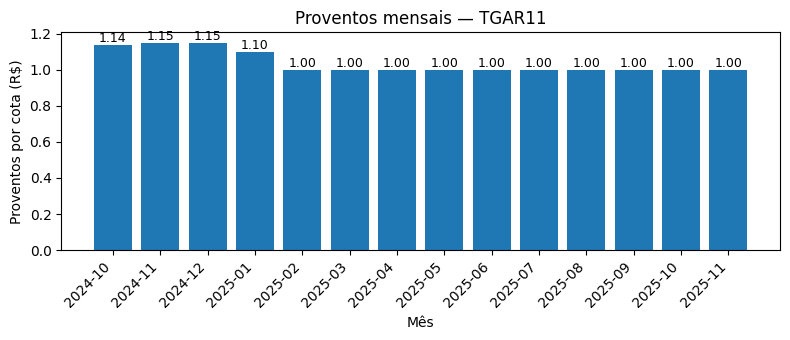

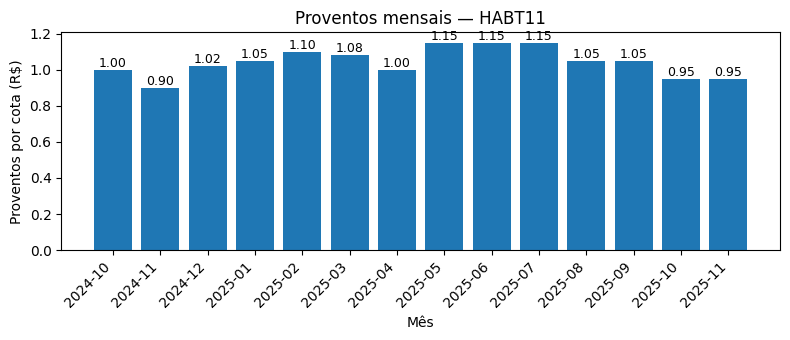

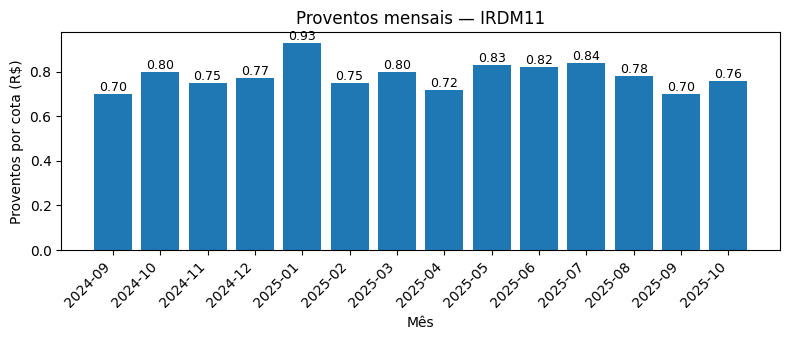

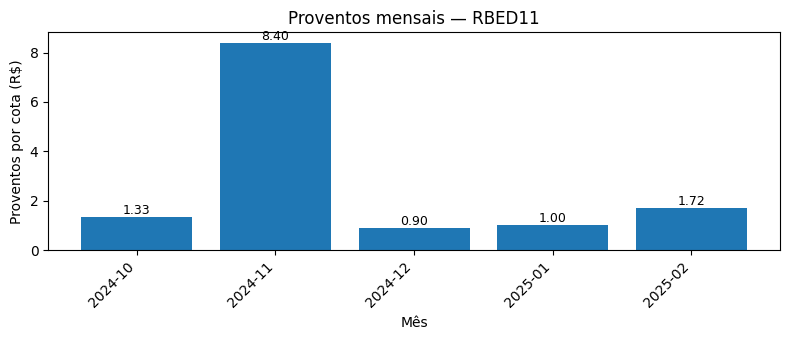

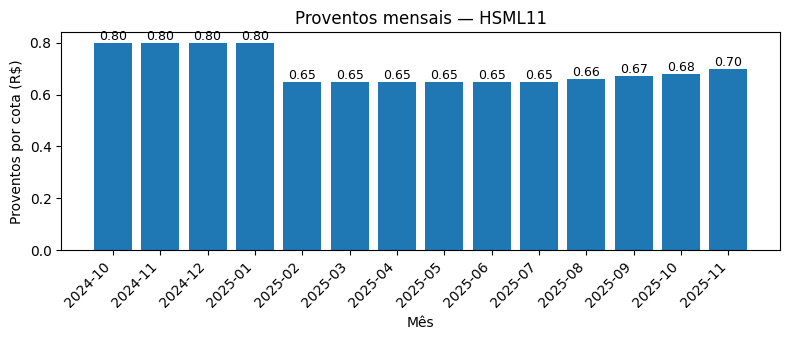

In [22]:
for tk in TICKERS:
    _, dividends = baixar_dados(tk)
    if dividends.empty:
        print(f"[AVISO] Sem dividendos para {tk}")
        continue

    # últimos 14 meses p/ folga
    recorte = dividends[dividends.index >= (datetime.now() - relativedelta(months=14))]
    if recorte.empty:
        print(f"[AVISO] Sem dividendos recentes para {tk}")
        continue

    mensal = recorte.groupby(recorte.index.to_period("M")).sum().to_timestamp()
    valores = mensal.values.flatten()
    labels = mensal.index.strftime("%Y-%m")

    plt.figure(figsize=(8, 3.5))
    barras = plt.bar(labels, valores)

    # Adiciona o valor no topo de cada barra
    for barra, valor in zip(barras, valores):
        plt.text(
            barra.get_x() + barra.get_width() / 2,
            barra.get_height(),
            f"{valor:.2f}",
            ha="center", va="bottom", fontsize=9
        )

    plt.title(f"Proventos mensais — {tk.replace('.SA','')}")
    plt.xlabel("Mês")
    plt.ylabel("Proventos por cota (R$)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(False)  # ❌ remove linhas horizontais
    plt.tight_layout()
    plt.show()


FASE 9 — Exportar resultados (CSV/Excel)

In [ ]:
# CSV
df.to_csv("fii_metricas.csv", index=False, encoding="utf-8-sig")

# Excel
with pd.ExcelWriter("fii_metricas.xlsx", engine="xlsxwriter") as xl:
    df.to_excel(xl, sheet_name="Métricas", index=False)
print("Arquivos salvos: fii_metricas.csv | fii_metricas.xlsx")
